In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
from tqdm import tqdm
import subprocess
import json
from mawkutils.data import SmoothKaggleDataSet, KaggleDataSet, ChunkedKaggleDataSet, DBManager as DBM
from mawkutils.experiments import evaluate_generalization
from visualize_performance import show_error_trajectories_4_diss
from mawkutils.render import prettify

IMG_PATH = Path().cwd().parent / 'notebooks' / 'img'
BIN_PATH = Path().cwd().parent / 'data' / "output" / "static_blackbox_estimates"
dataset_path = Path().cwd().parent / "data" / "input" / "measures_v2.csv"
fig_scale = 1.0


# Visual helper functions

In [2]:

# Add features for normalization, FE, EWMA/S
def summarize_MovAvg(ewma, ewms):
    if (ewms and ewma):
        return 'EWMA and EWMS'
    elif (ewms or ewma):
        return 'EWMA or EWMS'
    else:
        return 'Neither'

# Static black box models

In [3]:
meta_df = DBM.query("SELECT * FROM trials as t "
                    "LEFT JOIN experiments as e ON t.experiment_id = e.id "
                    "WHERE e.debug = false and e.scriptname = 'run_blackbox_static_4_diss.py' "
                    "and e.cv LIKE '%_static_diss' "
                    "and e.model_tag IN ('mlp', 'histgbm', 'svr', 'et', 'rf', 'lasso', 'ridge', 'ols') "
                    "ORDER BY t.mse ASC;")
                    
                    

Test ssh tunnel..ok


In [4]:
meta_df


,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,...,scriptname,hostname,debug,dataset,n_folds,input_cols,target_cols,model_size,comment,layer_cfg
0,3791,2022-12-01 18:53:59,2022-12-01 19:16:06,0,3.582900,13.650440,-24.273140,3791,mlp,mse,...,run_blackbox_static_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1380,fe_basic norm_custom ewm adjust=False,"{""f"": [{""units"": 16, ""activation"": ""relu""}, {""..."
1,3807,2022-12-01 20:55:06,2022-12-01 21:12:12,1,3.725863,17.191023,-22.587364,3807,mlp,mse,...,run_blackbox_static_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1124,fe_extensive norm_minmax ewm adjust=False,"{""f"": [{""units"": 16, ""activation"": ""relu""}, {""..."
2,3786,2022-12-01 18:31:14,2022-12-01 18:51:22,5,4.122736,16.802370,-21.658472,3786,mlp,mse,...,run_blackbox_static_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1380,fe_basic norm_minmax ewm adjust=False,"{""f"": [{""units"": 16, ""activation"": ""relu""}, {""..."
3,3786,2022-12-01 18:31:14,2022-12-01 18:49:42,3,4.137472,12.627246,-17.728981,3786,mlp,mse,...,run_blackbox_static_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1380,fe_basic norm_minmax ewm adjust=False,"{""f"": [{""units"": 16, ""activation"": ""relu""}, {""..."
4,3833,2022-12-01 22:03:50,2022-12-01 22:32:11,8,4.191840,15.797906,-19.560484,3833,mlp,mse,...,run_blackbox_static_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1956,fe_extensive norm_minmax ewm adjust=False,"{""f"": [{""units"": 16, ""activation"": ""relu""}, {""..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,3747,2022-12-01 15:42:18,2022-12-01 15:42:32,2,122.442310,62.736652,-90.304940,3747,rf,mse,...,run_blackbox_static_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",122498,fe_basic norm_standard ewm adjust=False,"{'n_jobs': -1, 'max_depth': 10, 'n_estimators'..."
2589,3682,2022-12-01 13:48:47,2022-12-01 13:48:59,8,123.182450,61.905357,-90.099630,3682,rf,mse,...,run_blackbox_static_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q}","{pm,stator_yoke,stator_tooth,stator_winding}",122648,fe_plain norm_minmax ewm adjust=False,"{'n_jobs': -1, 'max_depth': 10, 'n_estimators'..."
2590,3682,2022-12-01 13:48:08,2022-12-01 13:48:19,5,123.237600,62.129887,-90.669525,3682,rf,mse,...,run_blackbox_static_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q}","{pm,stator_yoke,stator_tooth,stator_winding}",122648,fe_plain norm_minmax ewm adjust=False,"{'n_jobs': -1, 'max_depth': 10, 'n_estimators'..."
2591,3672,2022-12-01 13:44:44,2022-12-01 13:44:57,1,123.289570,60.231320,-90.651490,3672,rf,mse,...,run_blackbox_static_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q}","{pm,stator_yoke,stator_tooth,stator_winding}",122582,fe_plain norm_standard ewm adjust=False,"{'n_jobs': -1, 'max_depth': 10, 'n_estimators'..."


In [5]:
# Add features for normalization, FE, EWMA/S
def summarize_MovAvg(ewma, ewms):
    if (ewms and ewma):
        return 'EWMA and EWMS'
    elif (ewms or ewma):
        return 'EWMA or EWMS'
    else:
        return 'Neither'


meta_df["FE"] = meta_df.comment.str.extract(r'fe_(\w+)')
meta_df["Norm"] = meta_df.comment.str.extract(r'norm_(\w+)').replace({'custom': 'limit', 'minmax': 'min-max'})
meta_df["EWMA"] = meta_df.input_cols.str.contains("_ewma_", case=False)
meta_df["EWMS"] = meta_df.input_cols.str.contains("_ewms_", case=False)
meta_df["Model"] = meta_df.model_tag.str.upper().str.replace("HISTGBM", "GBM")
meta_df['WorstCase'] = meta_df.loc[:, ["l_infty_over", "l_infty_under"]].abs().max(axis=1)
meta_df['Mov. Avgs.'] = meta_df.apply(lambda y: summarize_MovAvg(y.loc['EWMA'], y.loc['EWMS']), axis=1)
meta_df[["FE", "Norm", "EWMA", "EWMS"]]


,FE,Norm,EWMA,EWMS
0,basic,limit,True,True
1,extensive,min-max,True,False
2,basic,min-max,True,True
3,basic,min-max,True,True
4,extensive,min-max,True,True
...,...,...,...,...
2588,basic,standard,False,False
2589,plain,min-max,False,False
2590,plain,min-max,False,False
2591,plain,standard,False,False


In [6]:
# Overview table of MSE
black_box_overview = meta_df.groupby(["Model", "FE", "EWMA", "EWMS", "Norm"])["mse"]\
    .agg("min").unstack().unstack().unstack().round(2).loc[["OLS", "LASSO", "RIDGE", "SVR", "ET", "RF", "GBM", "MLP"], :]\
    .reindex(index=['plain', 'basic', 'extensive'], level=1)
black_box_overview

Norm              limit                      min-max                        \
EWMS              False         True           False          True           
EWMA              False  True   False  True    False  True    False  True    
Model FE                                                                     
OLS   plain      118.33  26.38  97.40  23.45  118.33  26.38   97.40  23.45   
      basic      107.20  17.66  86.81  12.56  107.20  17.66   86.81  12.56   
      extensive   83.64  15.43  83.81  11.07   83.64  15.43   83.81  11.07   
LASSO plain      122.37  25.00  99.86  21.64  117.99  23.67   95.10  20.47   
      basic      109.80  15.33  83.72  11.90  107.12  14.33   82.79  10.43   
      extensive  102.99  14.90  78.83  11.00   95.85  13.85   75.71   9.02   
RIDGE plain      118.33  25.92  97.29  23.51  118.33  25.89   97.23  23.34   
      basic      107.16  17.30  86.78  11.56  107.20  17.22   86.75  11.63   
      extensive   83.73  14.31  77.66  10.19   83.78  14.19   77.63  10.22   
SVR   plain      118.38  25.12  96.68  22.20  118.37  25.20   96.50  22.37   
      basic      107.06  15.68  86.88   9.33  107.19  15.79   86.11   9.67   
      extensive   83.85  12.79  75.06   7.28   83.74  13.12   75.14   7.86   
ET    plain       86.44  18.05  68.29  18.67   85.76  18.57   68.50  17.78   
      basic       84.89  14.91  65.71  15.03   86.94  15.57   66.47  15.56   
      extensive   88.56  14.98  61.75  14.20   86.82  14.82   65.80  15.04   
RF    plain      106.50  29.49  98.24  33.92  118.37  28.33  108.68  30.99   
      basic      102.53  24.67  95.35  26.59  116.04  29.52  101.24  34.09   
      extensive  110.28  24.48  92.15  25.59  110.73  29.18  102.49  30.70   
GBM   plain       70.41   9.17  46.64   9.59   70.39   9.16   46.64   9.60   
      basic       70.03   8.42  46.24   8.79   70.03   8.42   46.23   8.79   
      extensive   68.26   7.88  44.61   7.69   68.18   7.88   44.61   7.69   
MLP   plain       68.58   6.56  46.07   5.42   70.29   5.94   53.54   6.07   
      basic       64.62   4.24  42.33   3.58   72.50   4.91   41.27   4.12   
      extensive   55.96   4.66  40.40   4.24   56.39   3.73   41.04   4.19   

Norm            standard                        
EWMS               False          True          
EWMA               False  True    False  True   
Model FE                                        
OLS   plain       118.33  26.38   97.40  23.45  
      basic       107.20  17.66   86.81  12.56  
      extensive    83.64  15.43   83.81  11.07  
LASSO plain       118.32  24.81   96.68  22.33  
      basic       107.21  15.87   87.24   9.50  
      extensive    86.40  12.90   76.65   7.51  
RIDGE plain       118.33  26.35   97.39  23.45  
      basic       107.20  17.61   86.81  12.45  
      extensive    83.65  15.14   82.61  10.98  
SVR   plain       118.34  26.19   97.34  23.61  
      basic       107.20  17.41   86.76  11.70  
      extensive    83.65  14.53   79.28  10.34  
ET    plain        86.74  19.04   70.66  20.44  
      basic        87.42  16.22   66.61  16.75  
      extensive    89.04  15.30   68.60  15.75  
RF    plain       119.51  28.39  114.46  30.79  
      basic       118.44  29.67  104.61  29.94  
      extensive   112.85  27.02   98.80  27.15  
GBM   plain        70.39   9.17   45.97   9.59  
      basic        70.11   8.42   46.31   8.79  
      extensive    68.26   7.88   44.61   7.68  
MLP   plain        68.10   5.14   54.54   6.57  
      basic        67.98   4.73   54.01   4.75  
      extensive    56.55   4.78   59.60   4.46

In [7]:
# print to latex
print(black_box_overview.to_latex(
    label='tab:static_blackbox_grid_search', caption="Grid search for FE configurations with static black box models (minimum MSE in K² across seeds)"))

\begin{table}
\caption{Grid search for FE configurations with static black box models (minimum MSE in K² across seeds)}
\label{tab:static_blackbox_grid_search}
\begin{tabular}{llrrrrrrrrrrrr}
\toprule
 & Norm & \multicolumn{4}{r}{limit} & \multicolumn{4}{r}{min-max} & \multicolumn{4}{r}{standard} \\
 & EWMS & \multicolumn{2}{r}{False} & \multicolumn{2}{r}{True} & \multicolumn{2}{r}{False} & \multicolumn{2}{r}{True} & \multicolumn{2}{r}{False} & \multicolumn{2}{r}{True} \\
 & EWMA & False & True & False & True & False & True & False & True & False & True & False & True \\
Model & FE &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{OLS} & plain & 118.330000 & 26.380000 & 97.400000 & 23.450000 & 118.330000 & 26.380000 & 97.400000 & 23.450000 & 118.330000 & 26.380000 & 97.400000 & 23.450000 \\
 & basic & 107.200000 & 17.660000 & 86.810000 & 12.560000 & 107.200000 & 17.660000 & 86.810000 & 12.560000 & 107.200000 & 17.660000 & 86.810000 & 12.560000 \\
 & extensive & 83.6400

In [8]:
# model sizes for each FE scheme

model_sizes_df = meta_df\
    .groupby(["Model", "FE", "Mov. Avgs."])["model_size"]\
    .agg("min").unstack().unstack().round(2).loc[["OLS", "LASSO", "RIDGE", "SVR", "ET", "RF", "GBM", "MLP"], :]\
    .reindex(columns=['plain', 'basic', 'extensive'], level=1)\
    .reindex(columns=['Neither', 'EWMA or EWMS', 'EWMA and EWMS'], level=0)
model_sizes_df


Mov. Avgs. Neither                   EWMA or EWMS                    \
FE           plain   basic extensive        plain   basic extensive   
Model                                                                 
OLS             32      40        56          144     184       264   
LASSO           32      40        56          144     184       264   
RIDGE           32      40        56          144     184       264   
SVR             28      36        52          140     180       260   
ET          120458  120902    120500       121634  121778    121754   
RF          122582  122498    122486       122420  122402    122378   
GBM          18194   18194     18197        18197   18194     18182   
MLP            196     228       292          644     804      1124   

Mov. Avgs. EWMA and EWMS                    
FE                 plain   basic extensive  
Model                                       
OLS                  256     328       472  
LASSO                256     328       472  
RIDGE                256     328       472  
SVR                  252     324       468  
ET                122762  122654    122756  
RF                122834  122840    122834  
GBM                18200   18200     18197  
MLP                 1092    1380      1956

In [9]:
# print to latex
print(model_sizes_df.to_latex(
    label='tab:static_blackbox_grid_searchmodel_sizes',
    caption="Grid search for FE configurations with static black box models (number of model parameters)"))

\begin{table}
\caption{Grid search for FE configurations with static black box models (number of model parameters)}
\label{tab:static_blackbox_grid_searchmodel_sizes}
\begin{tabular}{lrrrrrrrrr}
\toprule
Mov. Avgs. & \multicolumn{3}{r}{Neither} & \multicolumn{3}{r}{EWMA or EWMS} & \multicolumn{3}{r}{EWMA and EWMS} \\
FE & plain & basic & extensive & plain & basic & extensive & plain & basic & extensive \\
Model &  &  &  &  &  &  &  &  &  \\
\midrule
OLS & 32 & 40 & 56 & 144 & 184 & 264 & 256 & 328 & 472 \\
LASSO & 32 & 40 & 56 & 144 & 184 & 264 & 256 & 328 & 472 \\
RIDGE & 32 & 40 & 56 & 144 & 184 & 264 & 256 & 328 & 472 \\
SVR & 28 & 36 & 52 & 140 & 180 & 260 & 252 & 324 & 468 \\
ET & 120458 & 120902 & 120500 & 121634 & 121778 & 121754 & 122762 & 122654 & 122756 \\
RF & 122582 & 122498 & 122486 & 122420 & 122402 & 122378 & 122834 & 122840 & 122834 \\
GBM & 18194 & 18194 & 18197 & 18197 & 18194 & 18182 & 18200 & 18200 & 18197 \\
MLP & 196 & 228 & 292 & 644 & 804 & 1124 & 1092 & 1380 & 

## Scatter plots

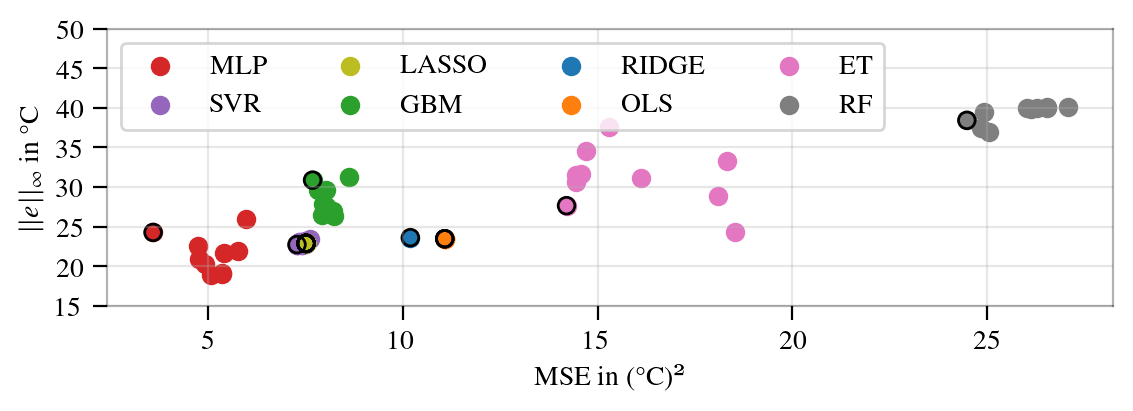

In [10]:
# Scatter of all best models
fig_scale = 1.0  # for seaborn "talk" context
fig_size = (6.49*fig_scale, 1.8*fig_scale)   # fit into diss format
best_models_df = meta_df.groupby("Model").apply(lambda grp: grp.loc[grp.mse == grp.mse.min(), :])\
    .loc[:, ["experiment_id", 'mse', 'WorstCase', "model_size", "Norm", "FE", "Mov. Avgs.", 'layer_cfg']]\
    .reindex(index=["RF", "ET", "GBM", "MLP", "OLS", "SVR", "LASSO", "RIDGE",], level=0)
colors = {'RF': 'tab:grey', 'ET': 'tab:pink', 'GBM': 'tab:green', 'MLP':'tab:red', 'OLS': 'tab:orange', 'SVR': 'tab:purple', 'LASSO': 'tab:olive', 'RIDGE': 'tab:blue'}
best_models_with_scatter_df = meta_df.query("experiment_id in @best_models_df.experiment_id")
fig = plt.figure(figsize=fig_size, dpi=200)
ax = fig.gca()
for mdl, mdl_df in best_models_with_scatter_df.groupby("Model", sort=False):
    ax.scatter(mdl_df.mse, mdl_df.WorstCase, label=mdl, color=colors[mdl])
for (mdl, _), mdl_vals in best_models_df.iterrows():
    ax.scatter(mdl_vals.mse, mdl_vals.WorstCase, facecolors="none", edgecolors='black')
ax.set_ylim(15, 50)
ax.set_yticks(range(15, 55, 5))
ax.legend(frameon=True, ncol=4)
ax.set_xlabel("MSE in (°C)²")
ax.set_ylabel("$||e||_\infty$ in °C")
prettify(ax)
#fig.savefig(IMG_PATH / 'diss_ests_static_blackbox_scatter.pdf', dpi=300, bbox_inches='tight')


In [12]:
best_models_df

experiment_id        mse  WorstCase  model_size      Norm  \
Model                                                                   
RF    1060           3799  24.480250  38.426517      122834     limit   
ET    713            3853  14.200295  27.654827      122756     limit   
GBM   168            3969   7.678968  30.877983       18197  standard   
MLP   0              3791   3.582900  24.273140        1380     limit   
OLS   554            3683  11.073225  23.478804         472   min-max   
      555            3684  11.073225  23.478804         472     limit   
      556            3681  11.073225  23.478804         472  standard   
SVR   137            3935   7.278706  22.737860         468     limit   
LASSO 154            3861   7.511797  22.888174         472  standard   
      155            3861   7.511797  22.888174         472  standard   
      156            3861   7.511797  22.888174         472  standard   
      157            3861   7.511797  22.888174         472  standard   
      158            3861   7.511797  22.888174         472  standard   
      159            3861   7.511797  22.888174         472  standard   
      160            3861   7.511797  22.888174         472  standard   
      161            3861   7.511797  22.888174         472  standard   
      162            3861   7.511797  22.888174         472  standard   
      163            3861   7.511797  22.888174         472  standard   
RIDGE 454            3721  10.190924  23.616650         472     limit   

                   FE     Mov. Avgs.  \
Model                                  
RF    1060  extensive   EWMA or EWMS   
ET    713   extensive  EWMA and EWMS   
GBM   168   extensive  EWMA and EWMS   
MLP   0         basic  EWMA and EWMS   
OLS   554   extensive  EWMA and EWMS   
      555   extensive  EWMA and EWMS   
      556   extensive  EWMA and EWMS   
SVR   137   extensive  EWMA and EWMS   
LASSO 154   extensive  EWMA and EWMS   
      155   extensive  EWMA and EWMS   
      156   extensive  EWMA and EWMS   
      157   extensive  EWMA and EWMS   
      158   extensive  EWMA and EWMS   
      159   extensive  EWMA and EWMS   
      160   extensive  EWMA and EWMS   
      161   extensive  EWMA and EWMS   
      162   extensive  EWMA and EWMS   
      163   extensive  EWMA and EWMS   
RIDGE 454   extensive  EWMA and EWMS   

                                                    layer_cfg  
Model                                                          
RF    1060  {'n_jobs': -1, 'max_depth': 10, 'n_estimators'...  
ET    713   {'n_jobs': -1, 'max_depth': 10, 'n_estimators'...  
GBM   168                    {'max_depth': 5, 'max_iter': 50}  
MLP   0     {"f": [{"units": 16, "activation": "relu"}, {"...  
OLS   554                                      {'n_jobs': -1}  
      555                                      {'n_jobs': -1}  
      556                                      {'n_jobs': -1}  
SVR   137   {'dual': False, 'loss': 'squared_epsilon_insen...  
LASSO 154                                   {'alpha': 0.0001}  
      155                                   {'alpha': 0.0001}  
      156                                   {'alpha': 0.0001}  
      157                                   {'alpha': 0.0001}  
      158                                   {'alpha': 0.0001}  
      159                                   {'alpha': 0.0001}  
      160                                   {'alpha': 0.0001}  
      161                                   {'alpha': 0.0001}  
      162                                   {'alpha': 0.0001}  
      163                                   {'alpha': 0.0001}  
RIDGE 454                                                  {}

In [11]:
# corresponding training times
training_times_df = meta_df.query(f"experiment_id in {best_models_df.experiment_id.tolist()}")\
    .assign(duration=lambda x: x.finished_at - x.started_at)\
    .groupby("Model")[["duration"]].agg("median").astype('timedelta64[s]')
training_times_df


,duration
Model,
ET,0 days 00:00:35
GBM,0 days 00:00:44
LASSO,0 days 00:13:02
MLP,0 days 00:18:14
OLS,0 days 00:00:12
RF,0 days 00:01:40
RIDGE,0 days 00:00:01
SVR,0 days 00:03:37


## Time series plots

In [12]:
best_model_ids = best_models_df.groupby('Model').apply(lambda x: x.iloc[-1, :])
best_model_ids


,experiment_id,mse,WorstCase,model_size,Norm,FE,Mov. Avgs.,layer_cfg
Model,,,,,,,,
ET,3853,14.200295,27.654827,122756,limit,extensive,EWMA and EWMS,"{'n_jobs': -1, 'max_depth': 10, 'n_estimators'..."
GBM,3969,7.678968,30.877983,18197,standard,extensive,EWMA and EWMS,"{'max_depth': 5, 'max_iter': 50}"
LASSO,3861,7.511797,22.888174,472,standard,extensive,EWMA and EWMS,{'alpha': 0.0001}
MLP,3791,3.582900,24.273140,1380,limit,basic,EWMA and EWMS,"{""f"": [{""units"": 16, ""activation"": ""relu""}, {""..."
OLS,3681,11.073225,23.478804,472,standard,extensive,EWMA and EWMS,{'n_jobs': -1}
RF,3799,24.480250,38.426517,122834,limit,extensive,EWMA or EWMS,"{'n_jobs': -1, 'max_depth': 10, 'n_estimators'..."
RIDGE,3721,10.190924,23.616650,472,limit,extensive,EWMA and EWMS,{}
SVR,3935,7.278706,22.737860,468,limit,extensive,EWMA and EWMS,"{'dual': False, 'loss': 'squared_epsilon_insen..."


In [13]:
kaggle_ds = KaggleDataSet()
show_mdls = ['MLP', 'LASSO', 'GBM']
file_mdl_map = {'MLP': 'mlp', 'LASSO': 'lasso', 'GBM': 'histgbm'}
mdl_ests = {}
for mdl, eid in best_model_ids.loc[show_mdls, 'experiment_id'].items():
    est_file = BIN_PATH / f'expid_{eid}_{file_mdl_map[mdl]}_estimates.pkl.bz2'
    if not Path.exists(est_file):
        host = meta_df.query(f"experiment_id == {eid}").hostname.iloc[0]
        print(f"SecureCopy experiment {eid} from {host}")
        subprocess.run(f"scp {host}:{est_file} {est_file}", shell=True)
    mdl_est = pd.read_pickle(est_file)
    mdl_est.loc[:, kaggle_ds.target_cols] *= 100#kaggle_ds.temperature_scale
    mdl_ests[mdl] = mdl_est



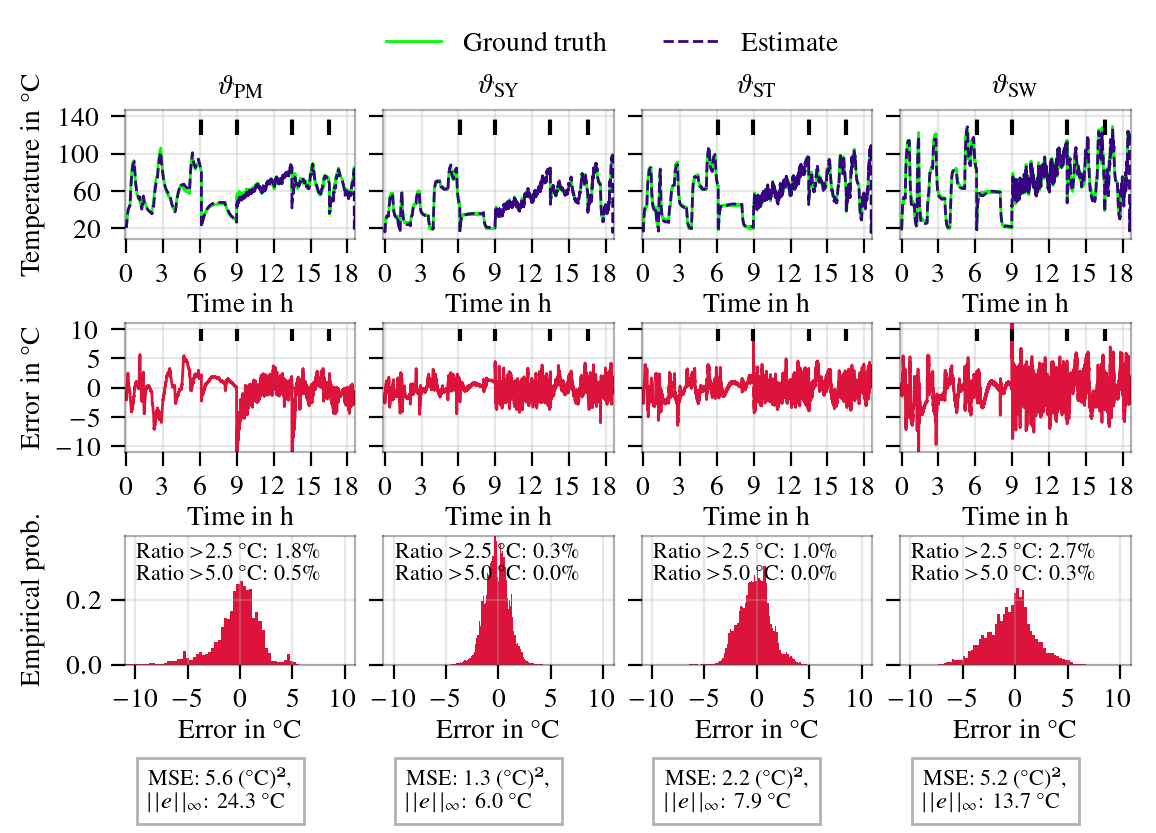

In [14]:
fig = show_error_trajectories_4_diss(mdl_ests['MLP'], dataset=kaggle_ds)
#fig.savefig(IMG_PATH / 'diss_ests_static_blackbox_mlp_ts.jpg', dpi=300, bbox_inches='tight')

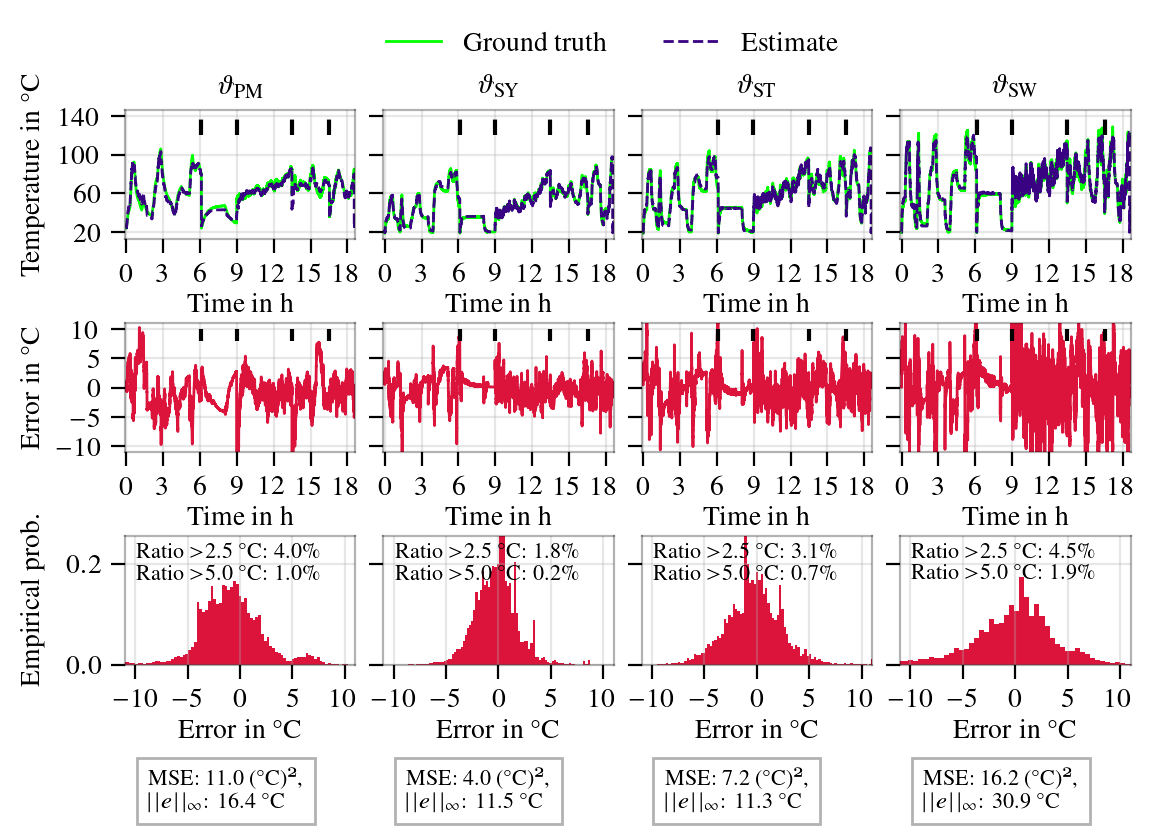

In [15]:
fig = show_error_trajectories_4_diss(mdl_ests['GBM'], dataset=kaggle_ds)
#fig.savefig(IMG_PATH / 'diss_ests_static_blackbox_gbm_ts.jpg', dpi=300, bbox_inches='tight')

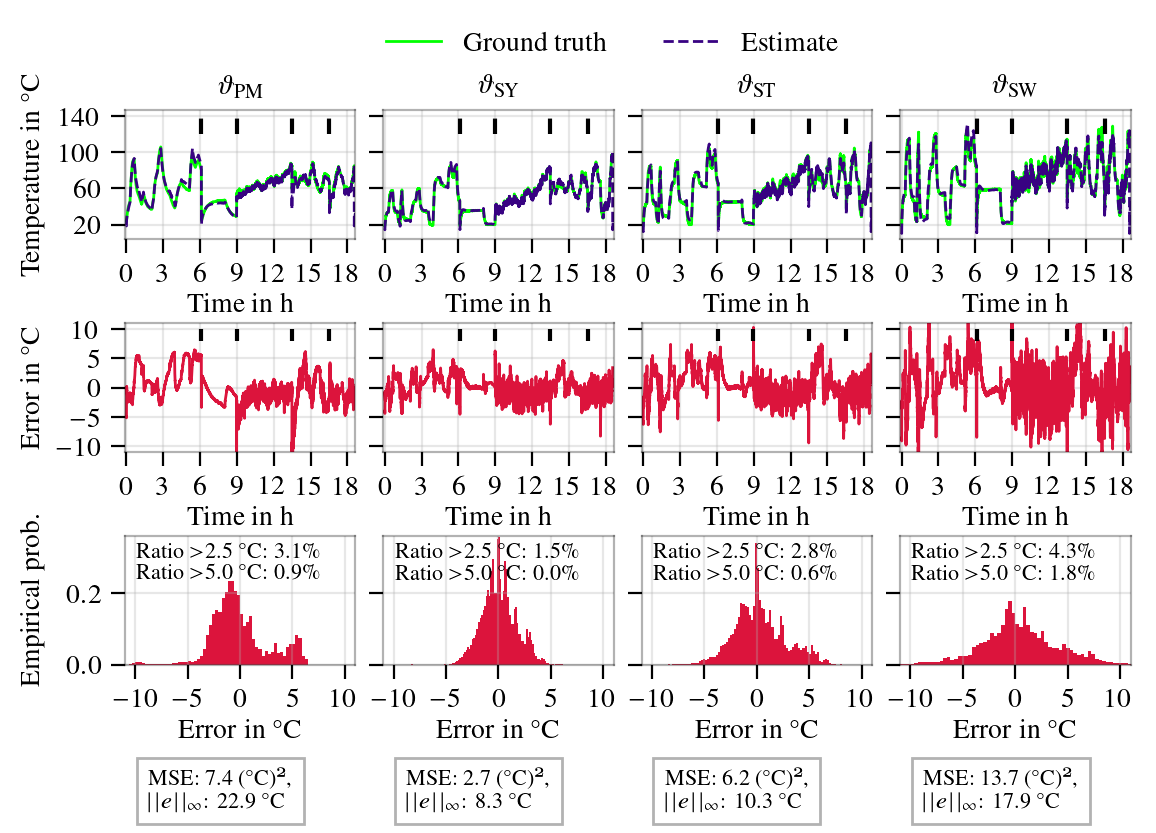

In [16]:
fig = show_error_trajectories_4_diss(mdl_ests['LASSO'], dataset=kaggle_ds)
#fig.savefig(IMG_PATH / 'diss_ests_static_blackbox_lasso_ts.jpg', dpi=300, bbox_inches='tight')

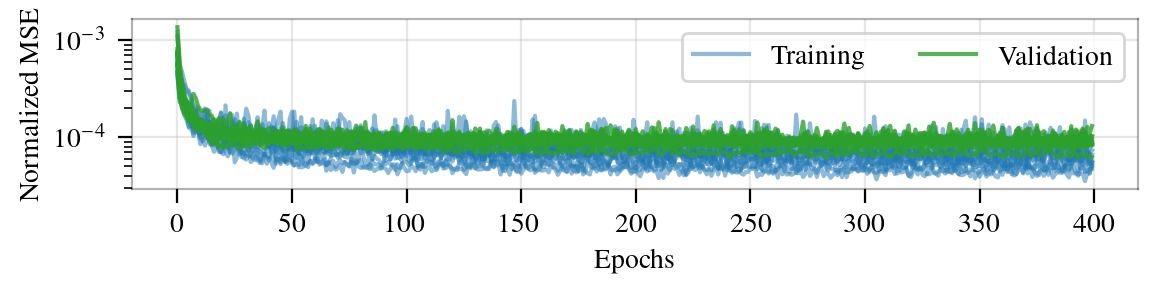

In [17]:
# Best MLP training trend
fig_scale = 1.0  # for seaborn "talk" context
fig_size = (6.49*fig_scale, 1.1*fig_scale)   # fit into diss format
eid = best_model_ids.at['MLP', 'experiment_id']
trend_file = BIN_PATH.parent / 'node_estimates'/ 'indexed_trends' / f'expid_{eid}_mlp_trends.pkl.bz2'

if not Path.exists(trend_file):
    host = meta_df.query(f"experiment_id == {eid}").hostname.iloc[0]
    print(f"SecureCopy experiment {eid} from {host}")
    subprocess.run(f"scp {host}:{trend_file} {trend_file}", shell=True)
trend_df = pd.read_pickle(trend_file)
fig, ax = plt.subplots(figsize=fig_size, dpi=200)
for rep_i, rep_df in trend_df.groupby('rep'):
    ax.plot(rep_df.reset_index(drop=True).training,
            color='tab:blue', label='Training', alpha=0.5)
    if not rep_df.validation.isna().any():
        ax.plot(rep_df.reset_index(drop=True).validation,
                color='tab:green', label='Validation', alpha=0.8, zorder=3)
    if rep_i == 0:
        ax.legend(frameon=True, ncols=2)
ax.set_xlabel('Epochs')
#if ax == axes[0, 0] or ax == axes[1, 0]:
ax.set_ylabel('Normalized MSE')
ax.set_yscale('log')
prettify(ax)
#fig.savefig(IMG_PATH / 'diss_mlp_trend_fe_grid.pdf', dpi=300, bbox_inches='tight')


## Box plots

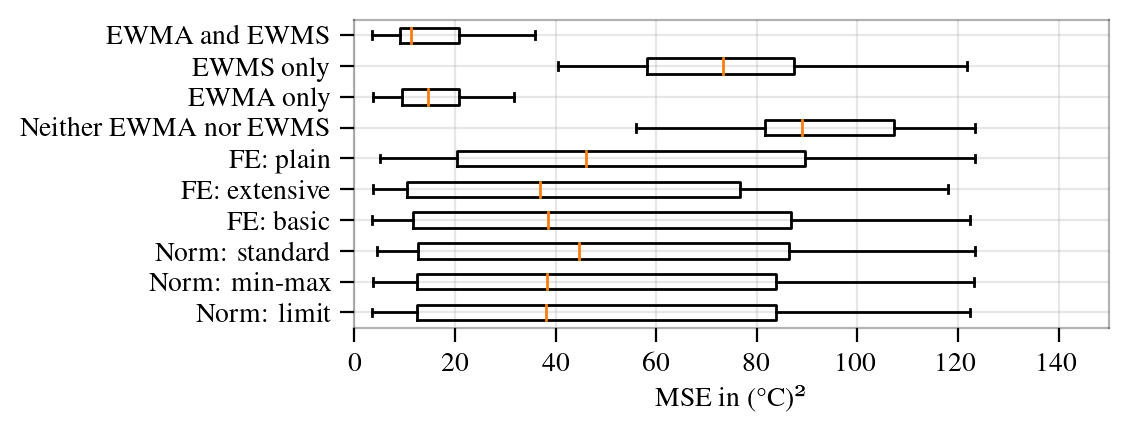

In [18]:
fig_size = (0.75*6.49*fig_scale, 2.0*fig_scale)   # fit into diss format (3/4 width due to long y labels)
fig = plt.figure(figsize=fig_size, dpi=200)
ax = fig.gca()
datasets = []
labels = []
for norm_lbl, df in meta_df.groupby('Norm', sort=False):
    datasets.append(df.mse)
    labels.append("Norm: " + norm_lbl)
    
for fe_lbl, df in meta_df.groupby("FE", sort=False):
    datasets.append(df.mse)
    labels.append("FE: " + fe_lbl)
datasets.extend([meta_df.query("not EWMA and not EWMS").mse,
                meta_df.query("EWMA and not EWMS").mse,
                meta_df.query("not EWMA and EWMS").mse,
                meta_df.query("EWMA and EWMS").mse])
labels.extend(["Neither EWMA nor EWMS",
               "EWMA only", 'EWMS only', "EWMA and EWMS"])
ax.boxplot(datasets, labels=labels, vert=False)
ax.set_xlim(0, 150)
ax.set_xlabel("MSE in (°C)²")
prettify(ax)
#fig.savefig(IMG_PATH / 'diss_ests_static_blackbox_FE_schemes_boxplot.pdf', dpi=160, bbox_inches='tight')

# Dynamic black box models

In [19]:
meta_df = DBM.query("SELECT * FROM trials as t "
                    "LEFT JOIN experiments as e ON t.experiment_id = e.id "
                    "WHERE e.debug = false and e.scriptname = 'run_blackbox_dyn_4_diss.py' "
                    "and e.cv = '1fold_static_diss' "
                    "and (e.comment ilike '%10min tbptt%' and e.model_tag = 'tcn' "
                    " or e.model_tag in ('gru', 'lstm')) "
                    "ORDER BY t.mse ASC;")

Test ssh tunnel..ok


In [20]:
meta_df

,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,...,scriptname,hostname,debug,dataset,n_folds,input_cols,target_cols,model_size,comment,layer_cfg
0,33368,2023-01-29 19:14:09,2023-01-29 20:03:07,5,4.194090e+00,11.922503,-7.941529,33368,gru,mse,...,run_blackbox_dyn_4_diss.py,lea-skynet,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1752,grid_search fe_extensive,"{""residual"": false, ""f"": [{""units"": 16}, {""uni..."
1,33368,2023-01-29 19:14:07,2023-01-29 20:01:17,0,5.039276e+00,8.448432,-11.040697,33368,gru,mse,...,run_blackbox_dyn_4_diss.py,lea-skynet,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1752,grid_search fe_extensive,"{""residual"": false, ""f"": [{""units"": 16}, {""uni..."
2,33350,2023-01-29 05:44:24,2023-01-29 06:38:13,1,5.641543e+00,11.667496,-11.499152,33350,gru,mse,...,run_blackbox_dyn_4_diss.py,lea-skynet,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1560,grid_search fe_basic,"{""residual"": false, ""f"": [{""units"": 16}, {""uni..."
3,33350,2023-01-29 05:44:25,2023-01-29 06:29:29,7,5.749945e+00,12.031211,-12.846407,33350,gru,mse,...,run_blackbox_dyn_4_diss.py,lea-skynet,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1560,grid_search fe_basic,"{""residual"": false, ""f"": [{""units"": 16}, {""uni..."
4,33350,2023-01-29 05:44:24,2023-01-29 06:39:53,3,6.187740e+00,10.987796,-12.674899,33350,gru,mse,...,run_blackbox_dyn_4_diss.py,lea-skynet,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1560,grid_search fe_basic,"{""residual"": false, ""f"": [{""units"": 16}, {""uni..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,41729,2023-02-10 16:08:49,2023-02-10 16:13:43,5,2.498676e+03,24.713170,-129.001240,41729,tcn,mse,...,run_blackbox_dyn_4_diss.py,lea-ava,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q}","{pm,stator_yoke,stator_tooth,stator_winding}",1424,"1 hr chunk, 10min tbptt, dbl layer + dropout 0...","{""residual"": false, ""f"": [{""units"": 16}, {""uni..."
549,41729,2023-02-10 16:03:52,2023-02-10 16:08:52,3,3.136655e+03,29.380524,-129.001240,41729,tcn,mse,...,run_blackbox_dyn_4_diss.py,lea-ava,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q}","{pm,stator_yoke,stator_tooth,stator_winding}",1424,"1 hr chunk, 10min tbptt, dbl layer + dropout 0...","{""residual"": false, ""f"": [{""units"": 16}, {""uni..."
550,41943,2023-02-10 21:54:09,2023-02-10 22:02:09,7,3.369221e+03,13.551713,-129.001240,41943,tcn,mse,...,run_blackbox_dyn_4_diss.py,lea-ava,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",4208,"1 hr chunk, 10min tbptt, dbl layer + dropout 0...","{""residual"": false, ""f"": [{""units"": 16}, {""uni..."
551,41801,2023-02-10 18:27:57,2023-02-10 18:33:00,2,4.027839e+03,-18.325370,-129.001240,41801,tcn,mse,...,run_blackbox_dyn_4_diss.py,lea-ava,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1520,"1 hr chunk, 10min tbptt, dbl layer + dropout 0...","{""residual"": false, ""f"": [{""units"": 16}, {""uni..."


In [21]:
meta_df["FE"] = meta_df.comment.str.extract(r'fe_(\w+)')
meta_df["EWMA"] = meta_df.input_cols.str.contains("_ewma_", case=False)
meta_df["EWMS"] = meta_df.input_cols.str.contains("_ewms_", case=False)
meta_df["Model"] = meta_df.model_tag.str.upper()
meta_df["Residual"] = meta_df.layer_cfg.apply(lambda x: json.loads(x)['residual'])
meta_df['WorstCase'] = meta_df.loc[:, ["l_infty_over", "l_infty_under"]].abs().max(axis=1)
meta_df['Mov. Avgs.'] = meta_df.apply(lambda y: summarize_MovAvg(y.loc['EWMA'], y.loc['EWMS']), axis=1)
meta_df[["FE", "EWMA", "EWMS", "Residual"]]

,FE,EWMA,EWMS,Residual
0,extensive,False,False,False
1,extensive,False,False,False
2,basic,False,False,False
3,basic,False,False,False
4,basic,False,False,False
...,...,...,...,...
548,plain,False,False,False
549,plain,False,False,False
550,extensive,True,False,False
551,basic,False,False,False


In [22]:
# Overview table of MSE
black_box_overview_dyn = meta_df.groupby(["Model", "FE", "Residual", "EWMA", "EWMS",])["mse"]\
    .agg("min").unstack().unstack().unstack().round(2).loc[["LSTM", "GRU", "TCN"], :]\
    .reindex(index=['plain', 'basic', 'extensive'], level=1).dropna(axis=1)
black_box_overview_dyn

EWMS              False                          True        
EWMA              False           True           True        
Residual          False   True    False  True    False  True 
Model FE                                                     
LSTM  plain       73.31   35.12   10.25   8.14    9.76   8.59
      basic       65.03   51.12    7.72   7.71    7.88   8.00
      extensive   59.11   73.12    7.23   7.07    8.06   7.33
GRU   plain        9.28   91.09    8.19  18.93   13.10  18.82
      basic        5.64  118.25    7.88  20.76   10.07  14.89
      extensive    4.19   83.00    7.08  11.50   11.30  18.05
TCN   plain      314.27   96.93  251.13  10.98  271.31  10.28
      basic      307.62   96.16  257.85   8.09  262.06   7.66
      extensive  293.73   94.35  295.37   8.37  252.37   7.47

In [23]:
# print to latex
print(black_box_overview_dyn.to_latex(
    label='tab:dyn_blackbox_grid_search', 
    caption="Grid search for FE configurations with dynamic black box models (minimum MSE in K² across seeds)"))

\begin{table}
\caption{Grid search for FE configurations with dynamic black box models (minimum MSE in K² across seeds)}
\label{tab:dyn_blackbox_grid_search}
\begin{tabular}{llrrrrrr}
\toprule
 & EWMS & \multicolumn{4}{r}{False} & \multicolumn{2}{r}{True} \\
 & EWMA & \multicolumn{2}{r}{False} & \multicolumn{2}{r}{True} & \multicolumn{2}{r}{True} \\
 & Residual & False & True & False & True & False & True \\
Model & FE &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{LSTM} & plain & 73.310000 & 35.120000 & 10.250000 & 8.140000 & 9.760000 & 8.590000 \\
 & basic & 65.030000 & 51.120000 & 7.720000 & 7.710000 & 7.880000 & 8.000000 \\
 & extensive & 59.110000 & 73.120000 & 7.230000 & 7.070000 & 8.060000 & 7.330000 \\
\cline{1-8}
\multirow[t]{3}{*}{GRU} & plain & 9.280000 & 91.090000 & 8.190000 & 18.930000 & 13.100000 & 18.820000 \\
 & basic & 5.640000 & 118.250000 & 7.880000 & 20.760000 & 10.070000 & 14.890000 \\
 & extensive & 4.190000 & 83.000000 & 7.080000 & 11.500000 & 11.300000 & 18.05

In [24]:
# model sizes for each FE scheme
model_sizes_df = meta_df\
    .groupby(["Model", "FE", "Residual", "Mov. Avgs.",])["model_size"]\
    .agg("min").unstack().unstack().round(2).loc[["LSTM", "GRU", "TCN"], :]\
    .reindex(index=['plain', 'basic', 'extensive'], level=1)\
    .reindex(columns=['Neither', 'EWMA or EWMS', 'EWMA and EWMS'], level=0)\
    .rename(columns={"EWMA or EWMS": "EWMA only"}, level=0)
model_sizes_df

Mov. Avgs.      Neither       EWMA only       EWMA and EWMS       
Residual          False True      False True          False  True 
Model FE                                                          
LSTM  plain        1952  2148      3744  4388          5536   6628
      basic        2080  2308      4384  5188          6688   8068
      extensive    2336  2628      5664  6788          8992  10948
GRU   plain        1464  1660      2808  3452          4152   5244
      basic        1560  1788      3288  4092          5016   6396
      extensive    1752  2044      4248  5372          6744   8700
TCN   plain        1424  1620      2768  3412          4112   5204
      basic        1520  1748      3248  4052          4976   6356
      extensive    1712  2004      4208  5332          6704   8660

## Scatter 

Text(0, 0.5, '$||e||_\\infty$ in °C')

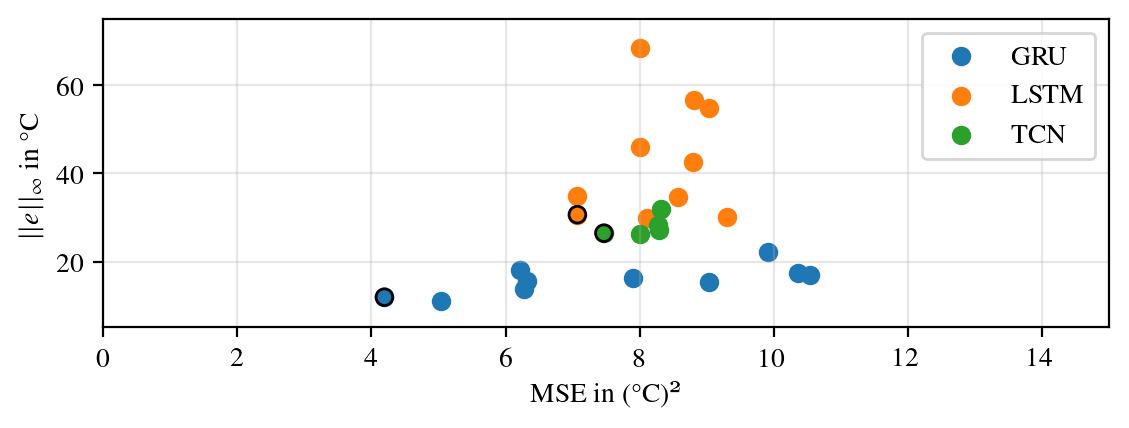

In [25]:
# Scatter of all best models
fig_scale = 1.0  # for seaborn "talk" context
fig_size = (6.49*fig_scale, 2.0*fig_scale)   # fit into diss format
best_models_df = meta_df.groupby("Model").apply(lambda grp: grp.loc[grp.mse == grp.mse.min(), :])\
    .loc[:, ["experiment_id", "seed", 'mse', 'WorstCase', "model_size", "Residual", "FE", "Mov. Avgs.", 'layer_cfg']]\
    .reindex(index=["LSTM", "GRU", "TCN"], level=0)
best_models_with_scatter_df = meta_df.query("experiment_id in @best_models_df.experiment_id")
fig = plt.figure(figsize=fig_size, dpi=200)
ax = fig.gca()
for mdl, mdl_df in best_models_with_scatter_df.groupby("Model", sort=False):
    ax.scatter(mdl_df.mse, mdl_df.WorstCase, label=mdl,)
for (mdl, _), mdl_vals in best_models_df.iterrows():
    ax.scatter(mdl_vals.mse, mdl_vals.WorstCase, facecolors="none", edgecolors='black')
ax.set_ylim(None, 75)
ax.set_xlim(0, 15)
ax.legend(frameon=True, ncol=1)
ax.set_xlabel("MSE in (°C)²")
ax.set_ylabel("$||e||_\infty$ in °C")
#fig.savefig(IMG_PATH / 'diss_ests_static_blackbox_scatter.pdf', dpi=160, bbox_inches='tight')

In [26]:
best_models_df

,,experiment_id,seed,mse,WorstCase,model_size,Residual,FE,Mov. Avgs.,layer_cfg
Model,,,,,,,,,,
LSTM,8,33376,5,7.071351,30.636623,6788,True,extensive,EWMA or EWMS,"{""residual"": true, ""f"": [{""units"": 16}, {""unit..."
GRU,0,33368,5,4.194090,11.922503,1752,False,extensive,Neither,"{""residual"": false, ""f"": [{""units"": 16}, {""uni..."
TCN,14,42002,11,7.466487,26.439380,8660,True,extensive,EWMA and EWMS,"{""residual"": true, ""f"": [{""units"": 16}, {""unit..."


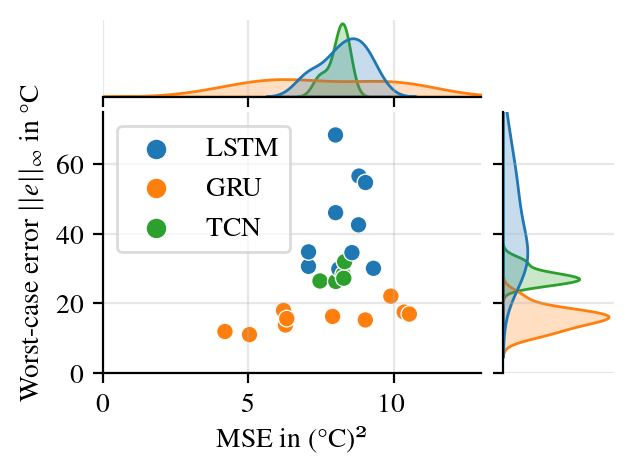

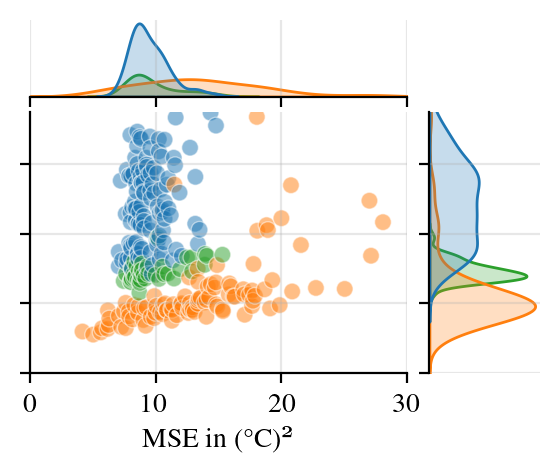

In [26]:
# seaborn jointplot
fig_scale = 1.0  # for seaborn "talk" context
fig_size = (0.45*6.49*fig_scale, 2*fig_scale)   # fit into diss format

g = sns.jointplot(data=best_models_with_scatter_df.query("mse < 15 and WorstCase < 75"),
         x='mse', y='WorstCase', hue='Model', ratio=3, hue_order=["LSTM", "GRU", "TCN"])
ax = g.fig.get_axes()[0]
ax.legend(loc='upper left', #bbox_to_anchor=(.1, 0.9),
          #bbox_transform=fig.transFigure, 
          frameon=True, framealpha=0.7)
ax.set_ylim([0, 75])
ax.set_xlim([0.0, 13])
ax.set_ylabel("Worst-case error $||e||_\infty$ in °C")
ax.set_xlabel("MSE in (°C)²")
ax.set_alpha(0.5)
g.fig.set_size_inches(*fig_size)
#g.fig.savefig(IMG_PATH / "diss_ests_dyn_blackbox_scatter_best_fe_ext.pdf", dpi = 300, bbox_inches = "tight")

g = sns.jointplot(data=meta_df.query("mse < 30 and WorstCase < 75"), alpha=0.5,
         x='mse', y='WorstCase', hue='Model', ratio=3, hue_order=["LSTM", "GRU", "TCN"])
ax = g.fig.get_axes()[0]
leg = ax.legend()
leg.set_visible(False)
ax.set_ylim([0, 75])
ax.set_xlim([0.0, 30])
ax.set_ylabel(None) #"Worst-case error $\ell_\infty$ in K")
ax.set_yticklabels([None])
ax.set_xlabel("MSE in (°C)²")
ax.set_alpha(0.5)
g.fig.set_size_inches(*fig_size)
#g.fig.savefig(IMG_PATH / "diss_ests_dyn_blackbox_scatter_all_fe_ext.pdf", dpi = 300, bbox_inches = "tight")

## Preliminary test runs

Test ssh tunnel..ok
SecureCopy model of experiment 40304 from n2cn0195


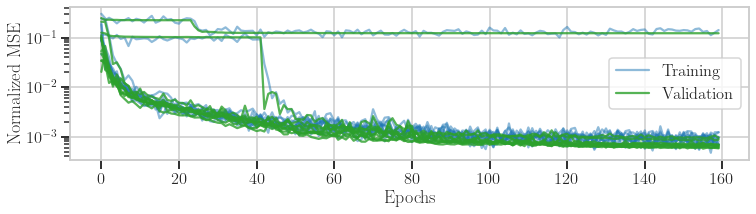

In [7]:
# train val trends
fig_scale = 1.875  # for seaborn "talk" context
fig_size = (6.49*fig_scale, 1.5*fig_scale)   # fit into diss format
eid = 40304  # tcn
trend_file = BIN_PATH.parent / 'node_estimates'/ 'indexed_trends' / f'expid_{eid}_tcn_trends.pkl.bz2'

if not Path.exists(trend_file):
    meta_info = DBM.query(f"Select hostname, model_tag, input_cols, target_cols, layer_cfg from experiments "
                                f"where id = {eid}").iloc[0, :]
    # find out host
    host = meta_info.hostname                                 
    print(f"SecureCopy model of experiment {eid} from {host}")
    if host.startswith("n2cn"):
        # pc2
        remote_path = f"/scratch/hpc-prf-neunet/wilhelmk/temp_project_files/projects/mawk-2/data/output/node_estimates/indexed_trends/{trend_file.name}"
        host = 'noctua2-ln3'
    else:
        remote_path = trend_file
    subprocess.run(f"scp {host}:{remote_path} {trend_file}", shell=True)
trend_df = pd.read_pickle(trend_file)
fig, ax = plt.subplots(figsize=fig_size)
for rep_i, rep_df in trend_df.groupby('rep'):
    ax.plot(rep_df.reset_index(drop=True).training,
            color='tab:blue', label='Training', alpha=0.5)
    if not rep_df.validation.isna().any():
        ax.plot(rep_df.reset_index(drop=True).validation,
                color='tab:green', label='Validation', alpha=0.8, zorder=3)
    if rep_i == 0:
        ax.legend(frameon=True)
ax.set_xlabel('Epochs')
#if ax == axes[0, 0] or ax == axes[1, 0]:
ax.set_ylabel('Normalized MSE')
ax.set_yscale('log')
#ax.set_title()

# Scatter of the final comparison


In [3]:
best_model_expids = {'LASSO': (3861, 0), # found after static blackbox overview
                     'MLP': (3791, 0),  # found after static blackbox overview
                     'LSTM': (33376, 5), # found after dynamic blackbox overview
                     'GRU': (42475, 4), # found among top 5 seeds after HPO
                     'Small GRU': (42194, 7),
                     'TCN': (41443, 6),  # found among top 5 seeds after HPO
                     'Small TCN': (39045, 9),
                        }

meta_df = DBM.query("SELECT * FROM trials as t "
                    "LEFT JOIN experiments as e ON t.experiment_id = e.id "
                    "WHERE e.debug = false and (" + 
                    ") or (".join(f'experiment_id = {i} and seed = {s}' for k, (i, s) in best_model_expids.items()) +
                    ") ORDER BY t.mse ASC;")
# overwrite gru and tcn with gen set performance (from NB 4.4)
meta_df.loc[meta_df.experiment_id == 42475, ['mse', 'l_infty_over', 'l_infty_under']] = (1.1478228869970326, 4.5261793136, -5.457063793) # gru
meta_df.loc[meta_df.experiment_id == 41443, ['mse', 'l_infty_over', 'l_infty_under']] = (7.14341, 16.9740, -24.266959) # tcn
meta_df.loc[meta_df.experiment_id == 42194, ['mse', 'l_infty_over', 'l_infty_under', 'model_tag']] = (2.126, 7.27530, -5.38, 'small gru') # small gru
meta_df.loc[meta_df.experiment_id == 39045, ['mse', 'l_infty_over', 'l_infty_under', 'model_tag']] = (15.59, 20.457374, -49.097, 'small tcn') # small tcn

Test ssh tunnel..ok


In [4]:
meta_df

,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,...,scriptname,hostname,debug,dataset,n_folds,input_cols,target_cols,model_size,comment,layer_cfg
0,42475,2023-02-11 16:19:00,2023-02-11 19:58:09,4,1.147823,4.526179,-5.457064,42475,gru,mse,...,hpo_dyn_mdl_4_diss.py,n2cn0511,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",24744,HPO study_4_diss trial-nr 724,"{""residual"": false, ""f"": [{""units"": 57, ""name""..."
1,42194,2023-02-11 07:04:07,2023-02-11 09:39:32,7,2.126000,7.275300,-5.380000,42194,small gru,mse,...,hpo_dyn_mdl_4_diss.py,n2cn0518,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1002,HPO study_4_diss trial-nr 465,"{""residual"": false, ""f"": [{""units"": 5, ""name"":..."
2,3791,2022-12-01 18:53:59,2022-12-01 19:16:06,0,3.582900,13.650440,-24.273140,3791,mlp,mse,...,run_blackbox_static_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1380,fe_basic norm_custom ewm adjust=False,"{""f"": [{""units"": 16, ""activation"": ""relu""}, {""..."
3,41443,2023-02-10 07:56:17,2023-02-10 08:38:48,6,7.143410,16.974000,-24.266959,41443,tcn,mse,...,hpo_dyn_mdl_4_diss.py,n2cn0446,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",48950,HPO study_2_4_diss trial-nr 3682,"{""residual"": false, ""f"": [{""units"": 57, ""name""..."
4,33376,2023-01-30 00:47:11,2023-01-30 02:03:10,5,7.071351,24.467104,-30.636623,33376,lstm,mse,...,run_blackbox_dyn_4_diss.py,lea-skynet,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",6788,grid_search fe_extensive,"{""residual"": true, ""f"": [{""units"": 16}, {""unit..."
5,3861,2022-12-02 03:04:57,2022-12-02 03:17:57,0,7.511797,16.573400,-22.888174,3861,lasso,mse,...,run_blackbox_static_4_diss.py,lea-ava,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",472,fe_extensive norm_standard ewm adjust=False,{'alpha': 0.0001}
6,39045,2023-02-08 11:20:03,2023-02-08 11:26:11,9,15.590000,20.457374,-49.097000,39045,small tcn,mse,...,hpo_dyn_mdl_4_diss.py,n2cn0191,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",1048,HPO study_2_4_diss trial-nr 1347,"{""residual"": false, ""f"": [{""units"": 4, ""name"":..."


In [5]:
meta_df["Model"] = meta_df.model_tag.str.upper()
meta_df['WorstCase'] = meta_df.loc[:, ["l_infty_over", "l_infty_under"]].abs().max(axis=1)
#meta_df = meta_df.iloc[[4, 0, 2, 1, 3], :]

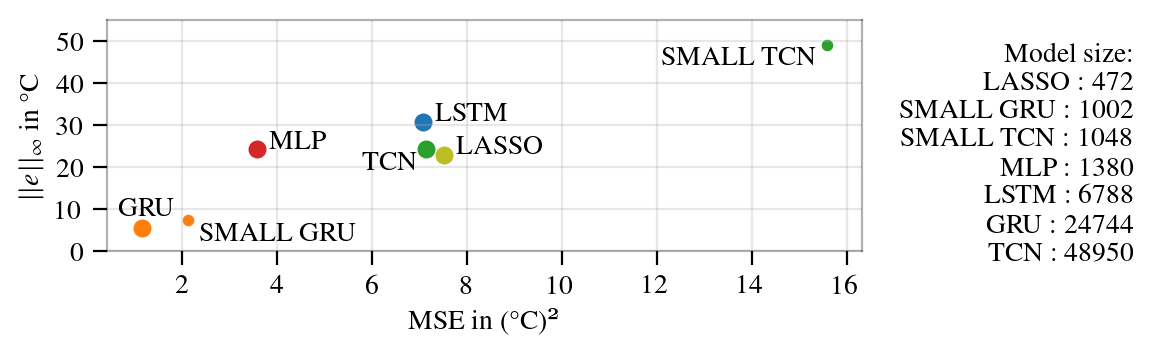

In [9]:
fig_size = (6.49*0.75, 1.5)   # fit into diss format
fig = plt.figure(figsize=fig_size, dpi=200)
ax = fig.gca()
color_code = {'GRU': 'tab:orange', 'SMALL GRU': 'tab:orange',
              'LSTM': 'tab:blue', 'MLP': 'tab:red', 'LASSO': 'tab:olive',
              'TCN': 'tab:green', 'SMALL TCN': 'tab:green'}
for mdl, mdl_df in meta_df.groupby("Model", sort=True):
    ax.scatter(mdl_df.mse, mdl_df.WorstCase, label=mdl, c=color_code[mdl], s=10 if mdl.startswith("SMALL") else 30)
    if mdl in ('SMALL TCN', 'TCN'):
        inc = [-0.2, -5]
    elif mdl == 'SMALL GRU':
        inc = [0.25, -5]
    elif mdl == 'GRU':
        inc = [-0.5, 3]
    else:
        inc = [0.25, 0.1]
    alignment = 'right' if mdl in ('SMALL TCN', 'TCN') else 'left'
    ax.annotate(mdl, xy=(mdl_df.mse, mdl_df.WorstCase), xytext=(mdl_df.mse+inc[0], mdl_df.WorstCase+inc[1]), horizontalalignment=alignment )
"""ax.legend(frameon=True, ncol=5, bbox_to_anchor=(.52, 0.9),
          bbox_transform=fig.transFigure, loc='lower center')"""
ax.text(s=f"{'Model size:' : ^10}\n" + '\n'.join(f"{row.Model:<10}: {str(row.model_size):>10}" for i, row in meta_df.sort_values('model_size').iterrows()),
        y=0.9, x=1.05, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', multialignment='right')
ax.set_xlabel("MSE in (°C)²")
ax.set_ylabel("$||e||_\infty$ in °C")
ax.set_ylim(0, 55)
ax.set_yticks(np.arange(0, 60, 10))
prettify(ax)
fig.savefig(IMG_PATH / "diss_perf_jointplot_blackbox.pdf", dpi = 300, bbox_inches = "tight")

# Dynamic nonlinear model, Expl. Euler discretized

In [20]:
meta_df = DBM.query("SELECT * FROM trials as t "
                    "LEFT JOIN experiments as e ON t.experiment_id = e.id "
                    "WHERE e.debug = false and e.scriptname = 'run_custom_dyn_experiment_4_diss.py' "
                    "and e.cv LIKE '%_static_diss' "
                    "and e.model_tag IN ('expleuler') "
                    "ORDER BY t.mse ASC;")
meta_df.head()

Test ssh tunnel..ok


,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,...,scriptname,hostname,debug,dataset,n_folds,input_cols,target_cols,model_size,comment,layer_cfg
0,85243,2023-03-21 21:05:10,2023-03-21 21:41:18,32,4.122200,9.821387,-7.506270,85243,expleuler,mse,...,run_custom_dyn_experiment_4_diss.py,lea-ava,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",708,"no temp_diffs, init also bias, no clip, more s...","{""f"": [{""units"": 32, ""activation"": ""relu""}, {""..."
1,85243,2023-03-21 19:58:57,2023-03-21 20:37:26,23,4.651422,7.032532,-12.840686,85243,expleuler,mse,...,run_custom_dyn_experiment_4_diss.py,lea-ava,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",708,"no temp_diffs, init also bias, no clip, more s...","{""f"": [{""units"": 32, ""activation"": ""relu""}, {""..."
2,85243,2023-03-21 19:54:01,2023-03-21 20:30:24,22,4.749617,6.435128,-11.696309,85243,expleuler,mse,...,run_custom_dyn_experiment_4_diss.py,lea-ava,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",708,"no temp_diffs, init also bias, no clip, more s...","{""f"": [{""units"": 32, ""activation"": ""relu""}, {""..."
3,85243,2023-03-21 21:05:53,2023-03-21 21:41:56,36,5.363355,10.049058,-7.919897,85243,expleuler,mse,...,run_custom_dyn_experiment_4_diss.py,lea-ava,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",708,"no temp_diffs, init also bias, no clip, more s...","{""f"": [{""units"": 32, ""activation"": ""relu""}, {""..."
4,85243,2023-03-21 21:41:53,2023-03-21 22:18:04,42,5.760171,6.580228,-15.839638,85243,expleuler,mse,...,run_custom_dyn_experiment_4_diss.py,lea-ava,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",708,"no temp_diffs, init also bias, no clip, more s...","{""f"": [{""units"": 32, ""activation"": ""relu""}, {""..."


(0.0001, 0.1)

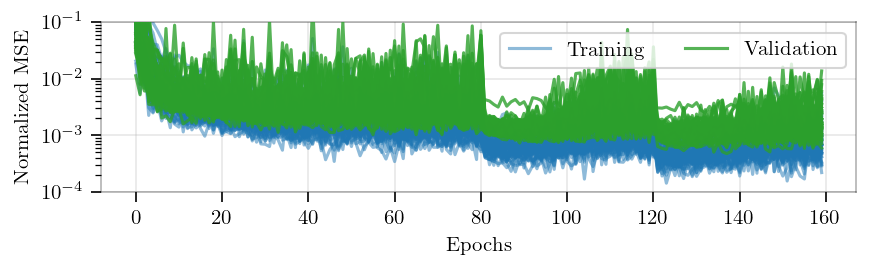

In [21]:
fig_scale = 1
fig_size = (6.49*fig_scale, 1.5*fig_scale)   # fit into diss format
eid, seed = 85243, 32
trend_file = BIN_PATH.parent / 'node_estimates'/ 'indexed_trends' / f'expid_{eid}_expleuler_trends.pkl.bz2'
trend_df = pd.read_pickle(trend_file)
fig, ax = plt.subplots(figsize=fig_size, dpi=150)
for rep_i, rep_df in trend_df.groupby('rep'):
    ax.plot(rep_df.reset_index(drop=True).training,
            color='tab:blue', label='Training', alpha=0.5)
    if not rep_df.validation.isna().any():
        ax.plot(rep_df.reset_index(drop=True).validation,
                color='tab:green', label='Validation', alpha=0.8, zorder=3)
    if rep_i == 0:
        ax.legend(frameon=True, ncols=2, loc="upper right")
ax.set_xlabel('Epochs')
ax.set_ylabel('Normalized MSE')
ax.set_yscale('log')
prettify(ax)
ax.set_ylim(1e-4, 1e-1)


In [22]:
est_file = BIN_PATH.parent / 'node_estimates'/ 'indexed_predictions' / f'expid_{eid}_expleuler_estimates.pkl.bz2'
mdl_est = pd.read_pickle(est_file).query("repetition == @seed")
kaggle_ds = KaggleDataSet()
mdl_est.loc[:, KaggleDataSet.target_cols] *= KaggleDataSet.temperature_scale

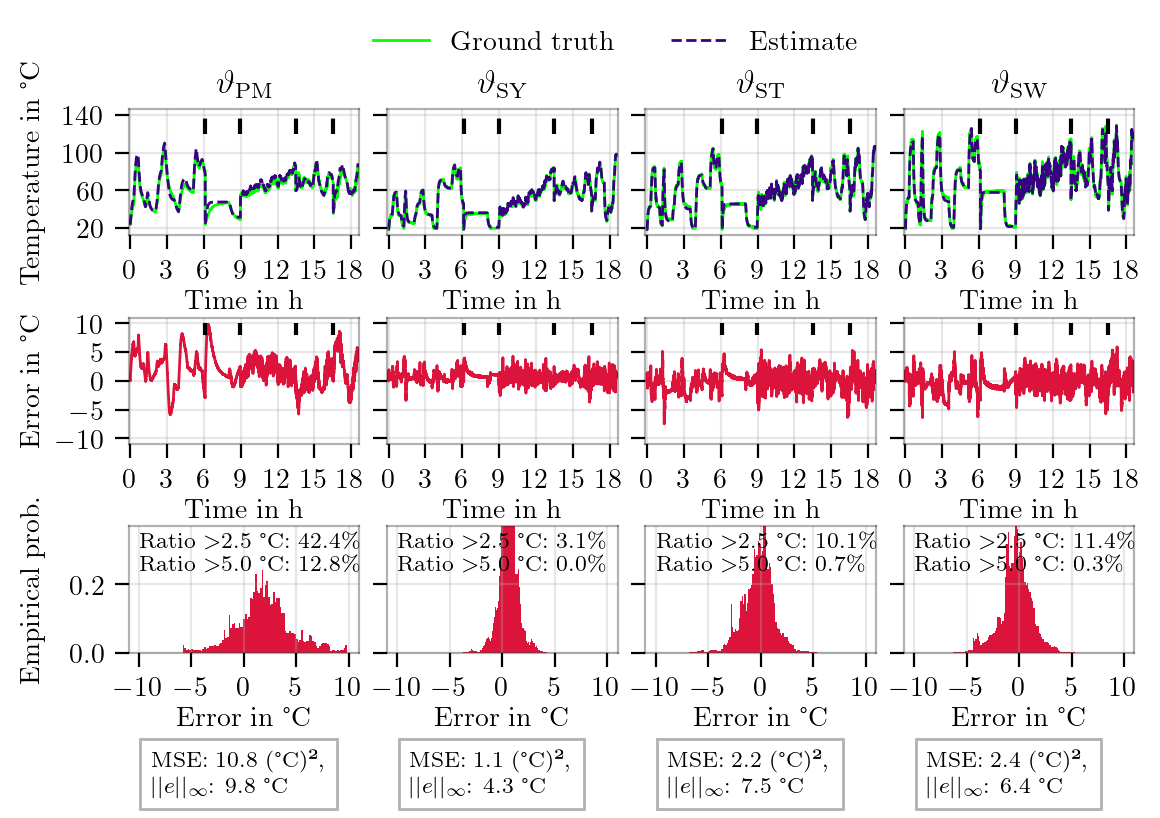

In [23]:
fig = show_error_trajectories_4_diss(mdl_est, dataset=kaggle_ds)
fig.savefig(IMG_PATH / 'diss_ests_expleuler_ts.jpg', dpi=300, bbox_inches='tight')